In [1]:
from astropy.io import votable
from urllib.parse import urlparse, parse_qs
import warnings
from ipyaladin import Aladin
import matplotlib.pyplot as plt
from beakerx import *
import plotly.graph_objects as go
import pandas
import seaborn as sns
import numpy as np
warnings.simplefilter('ignore')


import ipywidgets as widgets

%matplotlib inline

In [2]:
%%javascript
IPython.notebook.kernel.execute("notebook_url = '" + window.location + "'");


<IPython.core.display.Javascript object>

In [3]:
# table URL example: http://vizier.u-strasbg.fr/viz-bin/votable?-source=J%2FApJ%2F720%2F368%2Ftable5&-out.max=9999

query = urlparse(notebook_url).query
params = parse_qs(query)
table_url = params.get('table_url')
if table_url is None:
    print('table_url parameter has not been found in URL!\nEnter a table URL in text field below')
else:
    table_url = table_url[0]
    print(f'Let\'s analyze table {table_url}')
    
table_url_widget = widgets.Text(description='Table URL', value=table_url, layout=widgets.Layout(width='90%'))
table_url_widget

table_url parameter has not been found in URL!
Enter a table URL in text field below


Text(value='', description='Table URL', layout=Layout(width='90%'))

In [4]:
table_url = table_url_widget.value

## Retrieve and parse table

In [5]:
vot = votable.parse_single_table(table_url)
# retrieve all UCDs
ucd_list = [f.ucd for f in vot.fields]
print(f'{vot.nrows} rows retrieved')

4941 rows retrieved


## Convert to Pandas DataFrame

In [6]:
t = vot.to_table()
df = t.to_pandas()
# due to a bug in pandas, we cast all numeric columns to float64 type
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_columns] = df[numeric_columns].astype(np.float64)
# build dict column name-->UCD
name2ucd = dict(zip(df.columns.tolist(), ucd_list))


## Display table

In [7]:
table = TableDisplay(df)
for field_name in name2ucd:
    if name2ucd[field_name]=='pos.eq.ra;meta.main' or name2ucd[field_name]=='pos.eq.dec;meta.main':
        table.addCellHighlighter(TableDisplayCellHighlighter.getHeatmapHighlighter(field_name, TableDisplayCellHighlighter.SINGLE_COLUMN))
    elif name2ucd[field_name]=='src.redshift':
                table.addCellHighlighter(TableDisplayCellHighlighter.getHeatmapHighlighter(field_name, TableDisplayCellHighlighter.SINGLE_COLUMN, df[field_name].min(), df[field_name].max(), Color.WHITE, Color.RED))
    elif name2ucd[field_name].startswith('phot.mag'):
        table.addCellHighlighter(TableDisplayCellHighlighter.getHeatmapHighlighter(field_name, TableDisplayCellHighlighter.SINGLE_COLUMN, df[field_name].min(), df[field_name].max(), Color.WHITE, Color.YELLOW))
    elif name2ucd[field_name].startswith('phys.mass'):
        table.addCellHighlighter(TableDisplayCellHighlighter.getHeatmapHighlighter(field_name, TableDisplayCellHighlighter.SINGLE_COLUMN, df[field_name].min(), df[field_name].max(), Color.WHITE, Color.GREEN))


table

AttributeError: 'Series' object has no attribute 'get_values'

## Compute and display self-correlation matrix

<AxesSubplot:>

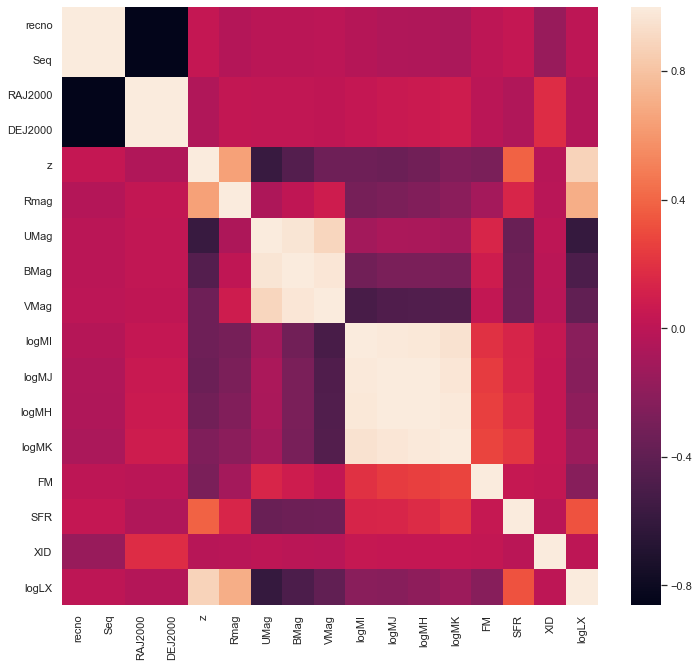

In [8]:
plt.figure(figsize=(12, 11))
sns.set()
corr = df.corr()

# plot the self-correlation matrix
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Interactive 2D scatter plot

In [9]:
x_scatter = widgets.Dropdown(
    options=numeric_columns,
    value=numeric_columns[0],
    description='X:'
)
y_scatter = widgets.Dropdown(
    options=numeric_columns,
    value=numeric_columns[1],
    description='Y:'
)
color_col_values = numeric_columns.copy()
color_col_values.insert(0, '<none>')
color_choice = widgets.Dropdown(
    options=color_col_values,
    value='<none>',
    description='Color by:'
)

opacity_slider = widgets.IntSlider(description='Opacity: ', value=100, continuous_update=False)

axis_selector = widgets.HBox([x_scatter, y_scatter, color_choice])

trace = go.Scatter(x=df[numeric_columns[0]], y=df[numeric_columns[1]], marker=dict(color= z, 
                      colorscale='Viridis', size=14, colorbar=dict(thickness=20))))
g = go.FigureWidget(  data=trace,
                      layout=go.Layout(
                        title=dict(
                            text='2D scatter'
                        ),
                        xaxis=dict(title=numeric_columns[0]), yaxis=dict(title=numeric_columns[1]),
                        height=550
                      )
                    )

def update_scatter(change):
    g.data = []
    marker={'opacity': opacity_slider.value/100.}
    if color_choice.value != '<none>':
        marker = dict(color=df[color_choice.value], colorscale='Viridis', showscale=True, opacity= opacity_slider.value/100.)
    
    trace = go.Scatter(x=df[x_scatter.value], y=df[y_scatter.value], mode='markers', marker=marker)
    g.add_trace(trace)
    g.layout.xaxis = {'title': x_scatter.value}
    g.layout.yaxis = {'title': y_scatter.value}
    
def update_opacity(change):
    with g.batch_update():
        g.data[0].marker.opacity = opacity_slider.value/100.


#    with g.batch_update():
#            g.data = trace
    

x_scatter.observe(update_scatter, names="value")
y_scatter.observe(update_scatter, names="value")
color_choice.observe(update_scatter, names="value")
opacity_slider.observe(update_opacity, names="value")
    
container = widgets.VBox([g, axis_selector, opacity_slider])
container

    'data': [{'mode': 'markers',
              'type': 'scatter',
              …

## SPLOM matrix

In [ ]:
toggle_buttons= {}
output = widgets.Output()

k = 0
for col in numeric_columns:
    enabled = True
    if k>5:
        enabled=False
    toggle_buttons[col] = widgets.ToggleButton(description=col, value=enabled)
    k+=1

update_splom_btn = widgets.Button(description='Update SPLOM')
toggle_disp = widgets.VBox([widgets.HBox([toggle_buttons[k] for k in toggle_buttons.keys()]), update_splom_btn, output])

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
def plot_splom(col_list):
    output.clear_output(wait=True)

    with output:
        (df[col_list].select_dtypes(include=[np.number])
       .pipe(sns.PairGrid)
       .map_upper(plt.scatter, marker='.', alpha=.25)
       .map_diag(sns.kdeplot)
       .map_lower(plt.hexbin, cmap=cmap, gridsize=20)
        );

def on_update_splom_btn(b):
    columns_to_keep = []
    for k in toggle_buttons:
        if toggle_buttons[k].value==True:
            columns_to_keep.append(k)
            
    plot_splom(columns_to_keep)

update_splom_btn.on_click(on_update_splom_btn)

display(toggle_disp)
on_update_splom_btn(update_splom_btn)


## Visualize table in ipyaladin

In [ ]:
a = Aladin(target='{} {}'.format(df['RAJ2000'].iloc[0], df['DEJ2000'].iloc[0]), fov=1)
a

In [ ]:
a.add_table(t)